# "How can you improve searching Github using machine learning? Text mining for Information Retrieval"

> "If you spend considerable amount of time searching or browsing Github like me, this presentation is for you. I was frustrated that sometimes I starred some repos, but then forgot what was their name, and couldn't retrieve them using GitHub's search engine.

In this presentation I will introduce Information Retrieval and tell about what it has in common with machine learning. I will show how unsupervised machine learning (Topic Models) can help in exploring starred repositories and for search."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]

In [1]:
#hide
!pip install gensim seaborn wordcloud rank_bm25 nltk ktrain holoviews datashader ktrain

In [2]:
import re
import tqdm
import requests

import numpy as np

from markdown import markdown
import nltk


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline

import rank_bm25


import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import bokeh.model
import bokeh.plotting
import bokeh.io
import re

import umap
from sklearn import metrics
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, dynspread
from holoviews.operation import decimate


import requests
from io import StringIO

bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
plt.style.use('ggplot')

In [4]:
def printmd(string):
    display(Markdown(string))
    

def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [5]:


def run_query(query, key): # A simple function to use requests.post to make the API call. Note the json= section.
    headers = {'Authorization': 'token ' + key}
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result, key):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string, key)

In [6]:
def get_starred_repo_information(key, n_pages=6):
    next_result = None
    starred_repo_information = []
    for __ in tqdm.tqdm(range(n_pages)):
      next_result = get_next_paged_result(next_result, key)
      starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']
    return starred_repo_information

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [7]:
# key = open('github_auth_key.txt', 'r').read().strip()
# starred_repo_information = get_starred_repo_information()

Since this notebook is hosted on github pages, we'll use cached dataset

In [8]:
import pickle
starred_repo_information = pickle.load(open('starred_repo_information.pkl', 'rb')) 

In [9]:
from nltk import stem, tokenize
lemmatizer = stem.WordNetLemmatizer()
lemmatizer.lemmatize('repositories')


def clean_and_stem(text):
    cleaned_text = re.sub('^[0-9a-zA-Z]+', ' ' , text.lower())
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenize.wordpunct_tokenize(cleaned_text)])


def get_cleaned_starred_repositories_df(repo_information):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['topics'] = repo_df['topics'].apply(lambda ts: [lemmatizer.lemmatize(t) for t in ts])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description_stemmed'] = repo_df['description'].apply(clean_and_stem)
    repo_df['description_keywords'] = repo_df['description_stemmed'].apply(summarization.keywords)
    repo_df['description_length'] = repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l))
    repo_df = repo_df[repo_df['description_length'] > 0]
    return repo_df

In [10]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [11]:
def plot_description_lengths(description_lengths):
    hist, edges = np.histogram(description_lengths.values, bins=25)
    median_description_length = description_lengths.median()
    mean_description_length = description_lengths.mean()

    p = bokeh.plotting.figure(
        title='Description length',
        x_axis_label='words in description',
        y_axis_label='number of repositories',
        plot_height=600, plot_width=800)
    p.quad(top=hist, left=edges[:-1], right=edges[1:], bottom=0)
    p.line([median_description_length, median_description_length], [0, 140], line_color='red')
    bokeh.plotting.show(p)

In [12]:
from bokeh import palettes


def plot_2d_data(data, text_label, cls, show_text=True, subset=None):
    palette = palettes.d3['Category20']
    x, y = data[:, 0], data[:, 1]
    source_df = pd.DataFrame({'x': x, 'y': y, 'text_label': text_label, 'color': [palette[c + 3][c] for c in cls]})
    source = bokeh.models.ColumnDataSource(source_df)

    TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,"
    
    p = bokeh.plotting.figure(tools=TOOLS, plot_width=800, plot_height=600)
    p.scatter(x='x', y='y', source=source, fill_color='color', line_color='color')


    if subset is not None:
        text_labels = bokeh.models.LabelSet(x='x', y='y', text='text_label', level='glyph',
                      x_offset=5, y_offset=5, source=bokeh.models.ColumnDataSource(source_df.iloc[subset]), render_mode='canvas', text_font_size='7pt')
        p.add_layout(text_labels)
    bokeh.plotting.show(p)

In [13]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

In [14]:
language_counts = starred_repo_df['primaryLanguage'].fillna('unspecified').value_counts()

# Programming language

In [15]:
p = bokeh.plotting.figure(x_range=list(language_counts.index), title='Repository number by language')

p.vbar(x=language_counts.index, top=language_counts, width=1)
p.xaxis.major_label_orientation = "vertical"
bokeh.plotting.show(p)

In [16]:
print(starred_repo_df['description_length'].describe())
plot_description_lengths(starred_repo_df['description_length'])

count    571.000000
mean      10.082312
std        6.451048
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       69.000000
Name: description_length, dtype: float64


In [17]:
starred_repo_df = starred_repo_df[starred_repo_df['description_length'] > 5]

# Topics word cloud

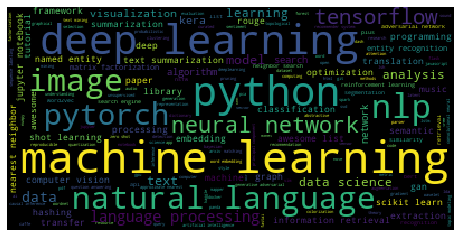

In [18]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

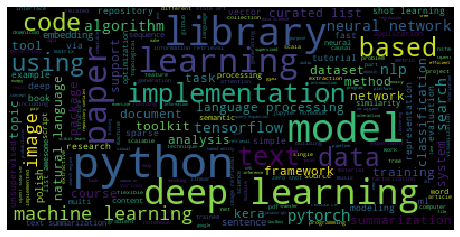

In [19]:
show_word_cloud_from_texts(starred_repo_df['description_stemmed'])

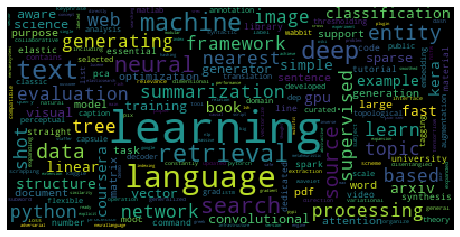

In [20]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

# Information retrieval crash course

We have a collection of documents $d_i$ and want to find some documents. 

We formulate a query $q$ for which the system returns some documents with relevance scores.

System can be evaluated (for queries with known responses) as a classifier.

Because of that we use precision and recall scores (why these instead of accuracy?)

Also we can use ranking metrics.

## Approaches

- substring matching

- break down texts into word and match them

## Honorable mention - inverted index


## The Vector Space Model

- represent documents and queries as vectors

- use similarity/disssimilarity (distance) to score vectors for a query

### Bag of Words

- TF-IDF, BM-25 can be interpreted as this - similarity is calculated as dot product in appropriate space

- `sklearn.text.preprocessing.{Count|TfIdf}Vectorizer`

**Now we can use machine learning!**

In [21]:
import rank_bm25 


class SearchEngine:
    
    def __init__(self, df, bm25_cls=rank_bm25.BM25Okapi, text_col='text'):
        self.bm25 = bm25_cls(df[text_col].str.split())
        self.df = df
        
    def search(self, query, k=100):
        scores = self.bm25.get_scores(query.split())
        #scores = scores[scores > 0]
        relevant_indices = np.argsort(-scores)[:k]
        return self.df.iloc[relevant_indices[scores[relevant_indices] > 0]]

    
search_engine = SearchEngine(starred_repo_df, text_col='description_stemmed')
search_engine.search('information retrieval')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,
musicinformationretrieval.com,Instructional notebooks on music information r...,stevetjoa,Jupyter Notebook,"[{'topic': {'name': 'ipython-notebook'}}, {'to...",stanford-mir\n============\n\n[![Stories in Re...,Jupyter Notebook,NaN,"[ipython-notebook, music-information-retrieval...",notebook on music information retrieval .,,6
anserini,A Lucene toolkit for replicable information re...,castorini,Java,"[{'topic': {'name': 'information-retrieval'}},...",Anserini\n========\n[![Build Status](https://t...,Java,NaN,"[information-retrieval, lucene]",lucene toolkit for replicable information retr...,retrieval,8
awesome-information-retrieval,A curated list of awesome information retrieva...,harpribot,NaN,[],# Awesome Information Retrieval [![Awesome](ht...,NaN,NaN,[],curated list of awesome information retrieval ...,retrieval,8
LIRE,Open source library for content based image re...,dermotte,Java,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# LIRE - Lucene Image Retrieval\nLIRE (Lucene ...,Java,NaN,"[image-retrieval, lira, multimedia]",source library for content based image retriev...,retrieval,12
wikIR,A python tool for building large scale Wikiped...,getalp,Python,[],# WIKIR\nA python tool for building large scal...,Python,NaN,[],python tool for building large scale wikipedia...,retrieval\nlarge,11
pytrec_eval,pytrec_eval is an Information Retrieval evalua...,cvangysel,C++,"[{'topic': {'name': 'information-retrieval'}},...",pytrec_eval\n===========\n\npytrec\_eval is a ...,C++,NaN,"[information-retrieval, evaluation]",_eval is an information retrieval evaluation t...,evaluation,14
query-expansion,Developing different methods for expanding a q...,phosseini,Python,[],# query-expansion\n\nThis repository is dedica...,Python,NaN,[],different method for expanding a query / topic...,expanding\nexpanded\nquery,19
cnnimageretrieval-pytorch,CNN Image Retrieval in PyTorch: Training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retrieval, convolutional-neural-network...",image retrieval in pytorch : training and eval...,retrieval,14
StarSpace,"Learning embeddings for classification, retrie...",facebookresearch,C++,[],"<p align=""center""><img width=""15%"" src=""exampl...",C++,NaN,[],"embeddings for classification , retrieval and ...",,7


### BM25 - a comment

BM comes from 'Best Match'

Difference between TF-IDF: is not symmetrical (query and documents are treated in a different way, for example because their lengths tend to differ) 

# Bag of Words

Pros:

- can be very fast
- easy to vectorize
- good if you actually want to search by phrase
    
Cons:

- extremely high dimensionality - use sparse vectors or die (waiting or RAM)
- troubles with polysemous words
- vocabulary mismatch problem - synonymy

In [22]:
from sklearn import feature_extraction 

vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2))
term_document_matrix = vectorizer.fit_transform(starred_repo_df['description_stemmed']) 
term_document_matrix.shape

(459, 5005)

In [23]:
search_engine.search('image')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,
open-images,Build an example image classifier using Google...,quiltdata,Jupyter Notebook,[],# open images\n\nThis repository contains the ...,Jupyter Notebook,NaN,[],an example image classifier using google open ...,image,10
nsfw_data_source_urls,Collection of NSFW images URLs for the purpose...,EBazarov,NaN,[],# NSFW data source URLs\n\n## Description\n\nR...,NaN,NaN,[],of nsfw image url for the purpose of training ...,,14
cnnimageretrieval-pytorch,CNN Image Retrieval in PyTorch: Training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retrieval, convolutional-neural-network...",image retrieval in pytorch : training and eval...,retrieval,14
FUNIT_tensorflow,Tensorflow Implementation of FUNIT: Few-Shot U...,zhangqianhui,Python,[{'topic': {'name': 'image-to-image-translatio...,# FUNIT_tensorflow\nTensorflow Implementation ...,Python,NaN,"[image-to-image-translation, few-shot-learning...",implementation of funit : few - shot unsupervi...,,8
imagehash,A Python Perceptual Image Hashing Module,JohannesBuchner,Python,[],NaN,Python,NaN,[],python perceptual image hashing module,perceptual,6
nsfw_data_scraper,Collection of scripts to aggregate image data ...,alex000kim,Shell,"[{'topic': {'name': 'nsfw-classifier'}}, {'top...",# NSFW Data Scraper\n\n## Note: use with cauti...,Shell,NaN,"[nsfw-classifier, nsfw, deep-learning, content...",of script to aggregate image data for the purp...,image,16
image-to-image-papers,🦓<->🦒 🌃<->🌆 A collection of image to image pa...,lzhbrian,NaN,"[{'topic': {'name': 'image-to-image'}}, {'topi...",# Image-to-Image papers\n\nA collection of ima...,NaN,NaN,"[image-to-image, generative-adversarial-networ...",🦓<->🦒 🌃<->🌆 a collection of image to image pap...,constantly,13
snowy,Small Image Library for Python 3,prideout,Python,"[{'topic': {'name': 'python'}}, {'topic': {'na...",[![Build Status](https://travis-ci.org/prideou...,Python,NaN,"[python, image-processing]",small image library for python 3,,6
image-match,🎇 Quickly search over billions of images,EdjoLabs,Python,"[{'topic': {'name': 'image-analysis'}}, {'topi...",[![PyPI](https://img.shields.io/pypi/status/im...,Python,NaN,"[image-analysis, image-signatures, python, sea...",🎇 quickly search over billion of image,,7


In [24]:
search_engine.search('picture')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,


## Can we do anything with nonexact matches?

- use different representation (word embeddings et c)

- change original representation

## Dimensionality reduction on text

- Latent Semantic Indexing (`sklearn.decomposition.TruncatedSVD`)

- topic models

## Topic modeling (repo descriptions)

Idea - documents are probability distributions over vocabulary

Model documents as mixtures of several latent factors 

This can be also considered as soft clustering (and turned into clustering by recovering the biggest component)

I used LDA and NMF here, chose NMF because results looked better

## TL;DR NMF is a simpler model than LDA, probably better here since we have only ~500 examples 

## Nonnegative Matrix Factorization

Assume $t$ number of topics.

Find nonnegative $L, T$ minimizing

$\|\underset{n \times v}{D} - \underset{n \times t}{L}\ \underset{t \times D}{T}\|^2_F$

Similar to PCA (rank constraint)

Can also add regularization

In [25]:
starred_repo_df.shape

(459, 11)

In [26]:
import ktrain


num_topics = 10 
tm = ktrain.text.get_topic_model(
    starred_repo_df['description_stemmed'],
    n_topics=num_topics,
    model_type='nmf',
    n_features=term_document_matrix.shape[1],
    lda_max_iter=10,
    min_df=1,
    verbose=0,
    hyperparam_kwargs={'nmf_alpha': 0.01, 'l1_ratio': 0.5, 'ngram_range': (1,1)}
)

using Keras version: 2.2.4-tf


In [27]:
tm.build(starred_repo_df['description_stemmed'])

In [28]:
tm.print_topics(show_counts=True)

topic:2 | count:50 | python using module retrieval http tool algorithm including leveldb implementation
topic:4 | count:33 | text summarization model using evaluation document extractive abstractive deep framework
topic:8 | count:32 | network neural paper list curated code shot zero repository resource
topic:0 | count:29 | learning deep machine shot book interactive scalable source representation model
topic:9 | count:27 | data library structure topological science manifold graph point neighborhood notebook
topic:3 | count:26 | language processing natural nlp polish art course state list datasets
topic:6 | count:22 | image pytorch retrieval implementation based nsfw open training classifier information
topic:5 | count:15 | search com vector talk semantic expansion engine query work build
topic:7 | count:13 | library machine support causal tree framework regression classification gradient inference
topic:1 | count:3 | model task code training semantic similarity achieve paper sentence r

In [29]:
reduced_term_document_matrix = tm.predict(starred_repo_df['description_stemmed'])
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_term_document_matrix, topic)[['description_stemmed']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

------
# Topic 1
------

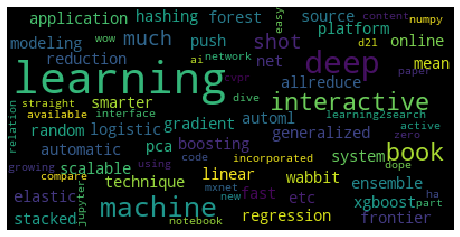

# Keywords

{'book',
 'deep',
 'interactive',
 'learning',
 'machine',
 'model',
 'representation',
 'scalable',
 'shot',
 'source'}

## **repositories representative for 1th topic:**

,description_stemmed
name,
h2o-3,source fast scalable machine learning platform...
vowpal_wabbit,wabbit is a machine learning system which push...
mxnet-the-straight-dope,interactive book on deep learning . much easy ...
LearningToCompare_ZSL,code for cvpr 2018 paper : learning to compare...
d2l-en,into deep learning : an interactive deep learn...


------
# Topic 2
------

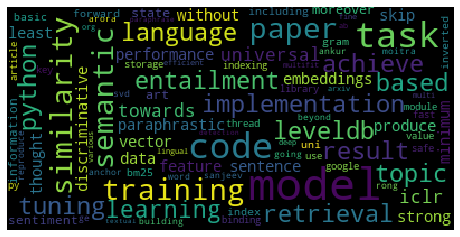

# Keywords

{'achieve',
 'code',
 'model',
 'paper',
 'result',
 'semantic',
 'sentence',
 'similarity',
 'task',
 'training'}

## **repositories representative for 2th topic:**

,description_stemmed
name,
iclr2016,code for training all model in the iclr paper ...
ir-python,python implementation for information retrieva...
anchor-baggage,"code for the article "" building topic model ba..."
multifit,"code to reproduce result from paper "" multifit..."
sentence-similarity,implementation of various deep learning model ...


------
# Topic 3
------

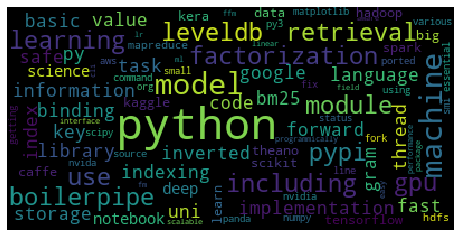

# Keywords

{'algorithm',
 'http',
 'implementation',
 'including',
 'leveldb',
 'module',
 'python',
 'retrieval',
 'tool',
 'using'}

## **repositories representative for 3th topic:**

,description_stemmed
name,
ir-python,python implementation for information retrieva...
data-science-ipython-notebooks,science python notebook : deep learning ( tens...
boilerpipe3,fork of boilerpipe with python 3 and small fix...
gputil,python module for getting the gpu status from ...
xlearn,"performance , easy - to - use , and scalable m..."


------
# Topic 4
------

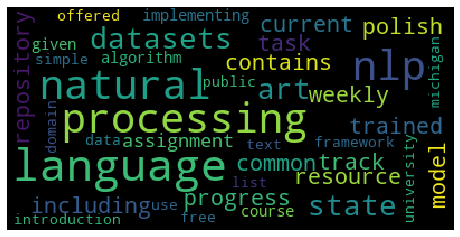

# Keywords

{'art',
 'course',
 'datasets',
 'language',
 'list',
 'natural',
 'nlp',
 'polish',
 'processing',
 'state'}

## **repositories representative for 4th topic:**

,description_stemmed
name,
NLP-progress,to track the progress in natural language proc...
polish-nlp-resources,- trained model and language resource for natu...
Introduction-to-Natural-Language-Processing-UMich-Coursera,repository contains weekly assignment on imple...
flair,very simple framework for state - of - the - a...
nlp-datasets,list of free / public domain datasets with tex...


------
# Topic 5
------

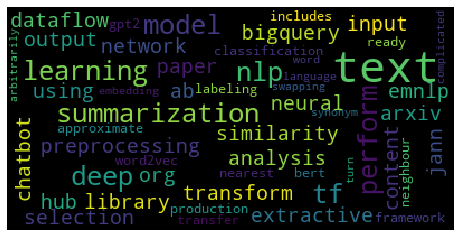

# Keywords

{'abstractive',
 'deep',
 'document',
 'evaluation',
 'extractive',
 'framework',
 'model',
 'summarization',
 'text',
 'using'}

## **repositories representative for 5th topic:**

,description_stemmed
name,
tf-textanalysis-gcp,how to perform text preprocessing using bigque...
nnsum,extractive neural network text summarization l...
jann,. i am jann . i am text input - text output ch...
Kashgari,is a production - ready nlp transfer learning ...
python-sirajnet,deep complicated nlp to turn your text into my...


------
# Topic 6
------

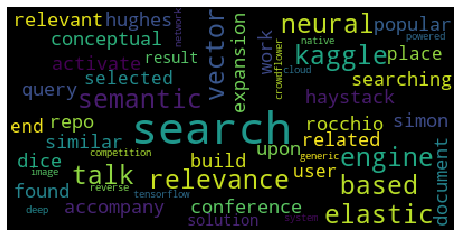

# Keywords

{'build',
 'com',
 'engine',
 'expansion',
 'query',
 'search',
 'semantic',
 'talk',
 'vector',
 'work'}

## **repositories representative for 6th topic:**

,description_stemmed
name,
VectorsInSearch,. com repo to accompany the dice . com ' vecto...
columbiau-rocchio-search-query-expander,"rocchio query expansion - similar to "" related..."
Kaggle_CrowdFlower,place solution for search result relevance com...
gnes,"is generic neural elastic search , a cloud - n..."
Image-to-Image-Search,reverse image search engine powered by elastic...


------
# Topic 7
------

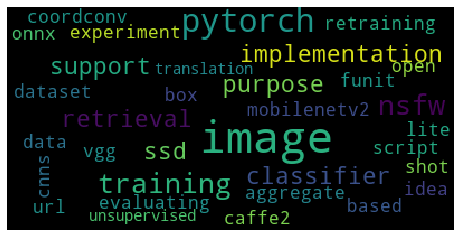

# Keywords

{'based',
 'classifier',
 'image',
 'implementation',
 'information',
 'nsfw',
 'open',
 'pytorch',
 'retrieval',
 'training'}

## **repositories representative for 7th topic:**

,description_stemmed
name,
cnnimageretrieval-pytorch,image retrieval in pytorch : training and eval...
pytorch-ssd,", mobilenetv2 , vgg based ssd / ssd - lite imp..."
nsfw_data_source_urls,of nsfw image url for the purpose of training ...
nsfw_data_scraper,of script to aggregate image data for the purp...
FUNIT_tensorflow,implementation of funit : few - shot unsupervi...


------
# Topic 8
------

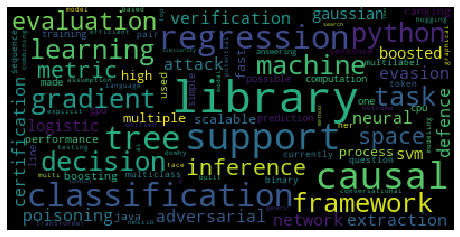

# Keywords

{'causal',
 'classification',
 'framework',
 'gradient',
 'inference',
 'library',
 'machine',
 'regression',
 'support',
 'tree'}

## **repositories representative for 8th topic:**

,description_stemmed
name,
adversarial-robustness-toolbox,library for adversarial machine learning ( eva...
catboost,"fast , scalable , high performance gradient bo..."
simpletransformers,"made simple with training , evaluation , and p..."
dowhy,is a python library for causal inference that ...
nmslib,- metric space library ( nmslib ): an efficien...


------
# Topic 9
------

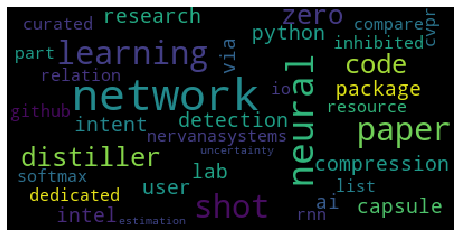

# Keywords

{'code',
 'curated',
 'list',
 'network',
 'neural',
 'paper',
 'repository',
 'resource',
 'shot',
 'zero'}

## **repositories representative for 9th topic:**

,description_stemmed
name,
ZeroShotCapsule,"for paper "" zero - shot user intent detection ..."
distiller,network distiller by intel ai lab : a python p...
awesome-rnn,neural network - a curated list of resource de...
LearningToCompare_ZSL,code for cvpr 2018 paper : learning to compare...
Inhibited-softmax,"with code for paper "" inhibited softmax for un..."


------
# Topic 10
------

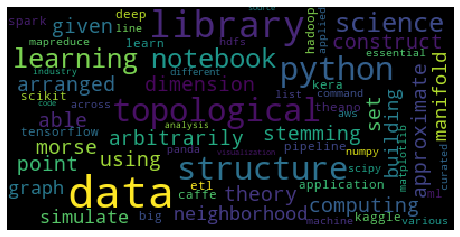

# Keywords

{'data',
 'graph',
 'library',
 'manifold',
 'neighborhood',
 'notebook',
 'point',
 'science',
 'structure',
 'topological'}

## **repositories representative for 10th topic:**

,description_stemmed
name,
topopy,library for computing topological data structu...
dagster,python library for building data application :...
data-science-ipython-notebooks,science python notebook : deep learning ( tens...
industry-machine-learning,curated list of applied machine learning and d...
ttk,- topological data analysis and visualization ...


In [30]:
topic_words = tm.get_topics()

for topic in range(num_topics):
    printmd("""------\n# Topic {}\n------""".format(topic+1))
    show_word_cloud_from_texts(representative_repos[topic]['description_stemmed'])
    printmd('# Keywords')
    display(set(topic_words[topic].split()))
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

In [31]:
tm.train_recommender(n_neighbors=3, metric='cosine')

In [32]:
def show_results(query):
    for res in tm.recommend(query, n=5, n_neighbors=3):
        print(res[0])
        print()

show_results('search')

and memory - efficient ann with a subset - search functionality

simple elasticsearch plugin wrapping around the search endpoint to provide rocchio query expansion

query expansion in semantic meta - search engine . the resulting expansion system is called wiki - metasemantik .

search engine with query expansion

. com repo to accompany the dice . com ' vector in search ' talk by simon hughes , from the activate 2018 search conference , and the ' searching with vector ' talk from haystack 2019 ( u ). build upon my conceptual search and semantic search work from 2015



In [33]:
show_results('query')

and memory - efficient ann with a subset - search functionality

simple elasticsearch plugin wrapping around the search endpoint to provide rocchio query expansion

rocchio query expansion - similar to " related search :" found at popular search engine but based on relevant document selected by the end - user

search engine with query expansion

. com repo to accompany the dice . com ' vector in search ' talk by simon hughes , from the activate 2018 search conference , and the ' searching with vector ' talk from haystack 2019 ( u ). build upon my conceptual search and semantic search work from 2015



In [34]:
show_results('information retrieval')

' s algorithm and general image generation theory and practice research , including pix2pix , cyclegan , ugatit , dcgan , singan and vae model ( tensorflow2 implementation ). deepnude的算法以及通用gan图像生成的理论与实践研究 。

image detector with rest interface developed using kera and flask

image retrieval in pytorch : training and evaluating cnns for image retrieval in pytorch

oxford and paris : large - scale image retrieval benchmarking

: octocat : various hashing method for image retrieval and serf a the baseline



## Visualizing repository 2D projection

Remark: ktrain also has visualization capability but I liked UMAP better

In [35]:
umap_red = umap.UMAP(metric='precomputed') 
umap_features = umap_red.fit_transform(metrics.pairwise.cosine_distances(reduced_term_document_matrix, reduced_term_document_matrix))

In [36]:
representatives = pd.concat(representative_repos)

In [37]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [38]:
umap_df = pd.DataFrame(umap_features)
umap_df.columns = ['x', 'y']
umap_df['name'] = starred_repo_df.index
umap_df['topic'] =  np.argmax(reduced_term_document_matrix, axis=1)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
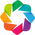

:Points   [x,y]   (name,topic)

In [39]:
hv.notebook_extension('bokeh','matplotlib')


opts.defaults(
    opts.RGB(width=400, height=400, xaxis=None, yaxis=None, show_grid=False, bgcolor="black"))



points = hv.Points(umap_df)
labels = hv.Labels(umap_df, ['x','y'], 'name')

points.opts(
    opts.Points(
        color='topic',
        cmap='Category20',
        tools=['zoom_in', 'zoom_out', 'hover'], width=800, height=600),
    opts.Overlay(width=800, height=600),
)

# More

* [my github profile - lambdaofgod](https://github.com/lambdaofgod)

* [GitHub GraphQL API](https://developer.github.com/v4/)

* [Information Retrieval book](https://nlp.stanford.edu/IR-book/information-retrieval-book.html)
* [LDA, Sparse Coding, Matrix Factorization and All That](https://www.cs.cmu.edu/~epxing/Class/10708-15/slides/LDA_SC.pdf)
* [ktrain](https://github.com/amaiya/ktrain) on github
* [BM25](https://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html)
* [UMAP](https://github.com/lmcinnes/umap)